In [117]:
import numpy as np
import h5py
import os
import scipy.io
import tensorflow as tf
import math
from scipy import optimize

def readdata():
    normalpath = './chessData_2017410/chessman_white_queen/normal_white_queen_0.txt'
    chesspath = './chessData_2017410/chessman_white_queen/pointCloud_white_queen_0.txt'
    normal = []
    pointCloud = np.zeros((1,3))
    file =  open(normalpath,'r')
    for line in file:
        #data = f.read().splitlines()
        #print([i[5] for i in data])    
        data = np.array(line)
        normal = np.fromstring(data, dtype=float, sep=" ")
        #normal = np.split(data,1)


    file =  open(chesspath,'r')
    for line in file:    
        #data = f.read().splitlines()
        data = np.array(line)
        data = np.fromstring(data, dtype=float, sep=" ")    
        pointCloud = np.append(pointCloud,data)


    pointCloud = pointCloud[3:pointCloud.shape[0]]
    N = pointCloud.shape[0] / 3
    pointCloud = np.transpose(pointCloud.reshape(N,3)) 

    #print(pointCloud)
    return pointCloud, normal


In [65]:
def normalize(vec, maxzero = 1e-12):
    norm_vec = np.linalg.norm(vec);
    if (norm_vec <= maxzero):
      vec_n = zeros(size(vec))
    else:
      vec_n = vec / norm_vec
    
    return vec_n
    
    #return vector / np.linalg.norm(vector)

In [66]:
#reference : https://github.com/3dptv/real_time_sobel_fpga_3dptv/blob/master/Matlab/beamsplitter/vrrotvec.m
def vrrotvec(chessnorm,target = [-1,0,0]):
    #print chessnorm.shape
    an = normalize(chessnorm)
    bn = normalize(target)
    #print("an")
    #print an
    #print("bn")
    #print bn
    
    ax = normalize(np.cross(chessnorm, target))    
    angle = math.acos(np.dot(an, bn)) 
    #print('dot')
    #print(np.dot(target, chessnorm))
    #print(np.dot(chessnorm, target))
    '''
    chessnorm = normalize(chessnorm)
    target = normalize(target)
    
    #cross
    cross = np.cross(chessnorm, target)
    cross = normalize(cross) 
    ac = math.acos(np.dot(chessnorm, target))
    '''
    return ax,angle
    

In [67]:
#reference: https://github.com/3dptv/real_time_sobel_fpga_3dptv/blob/master/Matlab/beamsplitter/vrrotvec2mat.m
def vrrotvec2mat(r):
    #print("r")
    #print r
    s = math.sin(r[3]);
    #print("s")
    #print s
    c = math.cos(r[3]);
    #print("c")
    #print c
    t = 1 - c;
    #print("t")
    #print t
    
    n = normalize(r[0:3])
    #print(n)
    #print(n.shape)
    x = n[0];
    y = n[1];
    z = n[2];
    m = [ 
     [t*x*x + c,    t*x*y - s*z,  t*x*z + s*y], 
     [t*x*y + s*z,  t*y*y + c,    t*y*z - s*x], 
     [t*x*z - s*y,  t*y*z + s*x,  t*z*z + c  ]
    ]
    return m

In [68]:
def modelnormalize(vertex):
    x = vertex[0,:]
    y = vertex[1,:]
    z = vertex[2,:]
    
    #print vertex.shape
    #print x.shape
    
    scale = 50/ (max(x) - min(x))
    #print scale
    #print max(x)
    xt = (min(x) + max(x))/2;
    yt = (min(y) + max(y))/2;
    zt = (min(z) + max(z))/2;
    #print xt
    #print yt
    #print zt
    
    x = (x - xt)*scale + xt;
    y = (y - yt)*scale + yt;
    z = (z - zt)*scale + zt;
    
    #new_vertex = np.append(x,y,axis = 1)
    #new_vertex = np.append(new_vertex, z, axis = 1)
    vertex_new = np.zeros((x.shape[0],3))
    vertex_new[:,0] = x;
    vertex_new[:,1] = y;
    vertex_new[:,2] = z;
    
    return vertex_new

In [69]:
def plot3(a,b,c,mark="o",col="r"):
  from matplotlib import pyplot
  import pylab
  from mpl_toolkits.mplot3d import Axes3D
  pylab.ion()
  fig = pylab.figure()
  ax = Axes3D(fig)
  ax.set_xlabel('x_label')
  ax.set_ylabel('y_label')
  ax.set_zlabel('z_label')
  ax.scatter(a, b, c,marker=mark,color=col)

In [132]:
def circlefit(x,y):
    upper = np.concatenate([x, y, np.ones((1,x.shape[1]))], axis = 0)
    upper = upper.conj().transpose()
    #print upper
    lower = np.array(-(np.power(x,2)+np.power(y,2)))
    lower = lower.conj().transpose()
    #print lower
    a = np.linalg.lstsq(upper,lower)
    #optimize.leastsq()
    #print a.shape
    #print('a',a)
    xc = -0.5*a[0][0]
    #print('xc',xc)
    yc = -0.5*a[0][1]
    #print('yc',yc)
    #print a
    return xc,yc
    

In [133]:
def rmnoise(vertex):
    xaxis = vertex[:,0]
    #print(xaxis)
    xaxis = np.sort(xaxis)
    #print(xaxis)
    #print(xaxis[0:199])
    temp = np.array(np.diff(xaxis[0:199],n=1,axis=0))
    #print(temp)
    index = np.array(np.where(temp >= 5))

    bottom = xaxis[index[0] +1];
    if not bottom.shape:
        #print("remove bottom")
        newvertex = vertex[:,np.where(vertex[:,0] > bottom)]
        newvertex[:,0] = newvertex[:,0] - bottom + 1
    else:
        #print("remain bottom")
        newvertex = vertex
        
    return newvertex

In [134]:
#pointcloud[3][n]
#normal[1][3]
def preprocess(pointCloud = None, desk_normal = None):
    #desk_normal = [-0.0054752,-0.165912,-0.289058]
    if pointCloud is None and desk_normal is None:
        pointCloud, desk_normal = readdata()
    #find rotation matrix
    cross,ac = vrrotvec(desk_normal)
    r = np.append(cross,ac)
    #print r
    Rtemp = vrrotvec2mat(r)
    #print("Rtemp")
    #print Rtemp
    R = np.dot([[1,0,0],[0,0,1],[0,-1,0]], Rtemp)
    
    #print("R")
    #print R
    #rotate point cloud
    pointCloud = np.dot(R, pointCloud)
    #print pointCloud.shape
    
    pointCloud = pointCloud.conj().transpose()
    #pointCloud = modelnormalize(pointCloud)
    #print pointCloud
    #print pointCloud.shape
    #transfer point cloud coordinate and translate to [0,Inf]
   
    pointCloud[:,0] = -pointCloud[:,0]
    pointCloud[:,0] = pointCloud[:,0] - min(pointCloud[:,0])+1;
    pointCloud[:,1] = pointCloud[:,1] - min(pointCloud[:,1])+1;
    pointCloud[:,2] = pointCloud[:,2] - min(pointCloud[:,2])+1;
    
    #print pointCloud
    ind = np.where(pointCloud[:,0] < 40)
    #print ind
    xc, yc = circlefit(pointCloud[ind,1],pointCloud[ind,2])
    #xc = (max(pointCloud[:,1])- min(pointCloud[:,1])) / 2
    #yc = (max(pointCloud[:,2])- min(pointCloud[:,2])) / 2
    #print xc,yc
    
    sy = round(xc[0]) - 25
    sz = round(yc[0]) - 25
    #print sy
    #print sz

    pointCloud = np.round(pointCloud)
    
    pointCloud = rmnoise(pointCloud)
    #print(pointCloud)
        
    x = pointCloud[:,0]
    y = pointCloud[:,1]
    z = pointCloud[:,2]

    y = y - sy
    z = z - sz
    
    answer = np.zeros((50,50,100))
    #print(x.shape[0])
    for pt in range(x.shape[0]):
        ""
        #print(y[pt])
        #print(z[pt])
        if x[pt] > 0 and x[pt] < 100 and y[pt] > 0 and y[pt] < 50 and z[pt] > 0 and z[pt] < 50:
            answer[z[pt],y[pt],x[pt]] = 1
            #print(int(z[pt]),int(y[pt]),int(x[pt]))
            #print()
            #print()
        else:
            print(x[pt], y[pt] ,z[pt])
    #print(answer)
    return answer, pointCloud
    
    #return pointCloud

In [135]:
#pointCloud, _  = readdata()
answer, pointCloud = preprocess()

(1.0, 18.0, 50.0)
(1.0, 17.0, 50.0)


/home/bonnie/.local/lib/python2.7/site-packages/ipykernel/__main__.py:65: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[ 3  3  3 ..., 46 48 48]


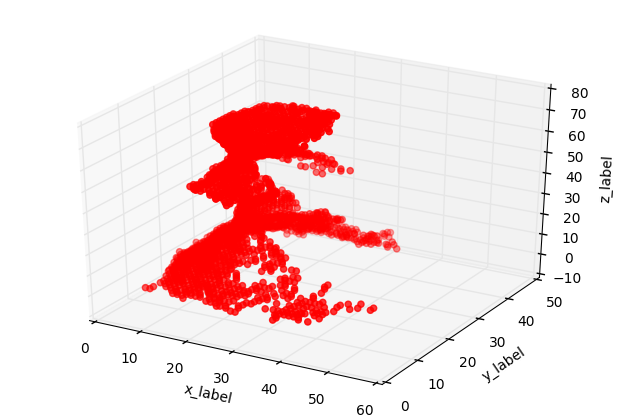

In [96]:
x,y,z = np.nonzero(answer)
print(x)
plot3(x,y,z)

#plot3(pointCloud[:,0],pointCloud[:,1],pointCloud[:,2])
#print min(pointCloud[:,0])

NameError: global name 'vector' is not defined